In [1]:
import os
import sys
from collections import defaultdict
from functools import reduce, partial
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import spatial

from mutspec.utils.annot import mutations_summary

## Compare mutations

### Simple

In [2]:
path_to_mutations = "../data/processed/nematoda/dif_approaches/simple/mutations.tsv"

mut = pd.read_csv(path_to_mutations, sep='\t')
mut["MutBase"] = mut["Mut"].str.slice(2, 5)
print(mut.shape)
mut.head()

(98697, 12)


,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,RefNode,AltNode,Gene,MutBase
0,T[T>G]T,0,6,3,ATT,ATG,I,M,Node4,Node5,ATP6,T>G
1,A[A>G]G,0,163,1,AGT,GGT,S,G,Node4,Node5,ATP6,A>G
2,A[G>A]T,0,208,1,GTT,ATT,V,I,Node4,Node5,ATP6,G>A
3,T[A>T]T,0,241,1,ATA,TTA,M,L,Node4,Node5,ATP6,A>T
4,T[A>T]A,0,274,1,AAT,TAT,N,Y,Node4,Node5,ATP6,A>T


In [3]:
mutations_summary(mut, "Gene")

,non-syn,syn,syn4f,Stop loss,Stop gain
Gene,,,,,
ATP6,1932,1562,1668,3,2
COX1,2338,4939,6444,3,1
COX2,1593,2325,2283,1,0
COX3,2030,2563,2928,4,0
CYTB,3441,3637,3998,4,3
ND1,2763,2954,3036,6,2
ND2,3861,2723,1851,5,4
ND3,1290,1088,863,3,0
ND4,4451,4024,4173,7,2


### Proba iqtree with evol coef

In [5]:
path_to_mutations_proba = "../data/processed/nematoda/dif_approaches/iqtree/mutations.tsv"

mut_proba = pd.read_csv(path_to_mutations_proba, sep='\t')
mut_proba["MutBase"] = mut_proba["Mut"].str.slice(2, 5)
print(mut_proba.shape)
mut_proba.head()

(11406382, 15)


,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,ProbaFull,RefNode,AltNode,Gene,MutBase
0,A[A>C]A,0,2,2,AAA,ACA,K,T,0.034795,0.000794,0.000551,Node4,Node5,ATP6,A>C
1,A[A>G]A,0,2,2,AAA,AGA,K,S,0.034795,0.000948,0.000658,Node4,Node5,ATP6,A>G
2,A[A>T]A,0,2,2,AAA,ATA,K,M,0.034795,0.011557,0.008018,Node4,Node5,ATP6,A>T
3,A[C>A]A,0,2,2,ACA,AAA,T,K,0.023225,0.000813,0.000564,Node4,Node5,ATP6,C>A
4,A[C>G]A,0,2,2,ACA,AGA,T,S,0.023225,0.000633,0.000439,Node4,Node5,ATP6,C>G


In [6]:
msum_pr = mutations_summary(mut_proba, "Gene", "ProbaFull")
msum_pr.round(1)

,non-syn,syn,syn4f,Stop loss,Stop gain,Stop to stop
Gene,,,,,,
ATP6,5697.2,2111.9,2147.5,143.1,140.1,12.7
COX1,4097.5,5844.0,7373.4,60.4,58.4,3.9
COX2,3765.8,2924.1,2615.1,71.7,69.7,5.8
COX3,3137.3,3129.4,3426.2,41.0,36.9,2.5
CYTB,5005.5,4393.4,4716.1,52.1,46.6,3.0
ND1,4653.2,3653.6,3700.5,64.3,60.2,3.5
ND2,8179.6,3713.2,2394.2,96.0,88.6,8.4
ND3,2184.0,1395.2,1081.2,29.7,27.3,2.4
ND4,6109.0,4896.1,5128.6,43.4,34.8,4.0


In [7]:
mut_proba.ProbaFull.max()

0.99935335

In [8]:
mut_proba[mut_proba.ProbaFull > 0.95]

,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,ProbaFull,RefNode,AltNode,Gene,MutBase
1863705,G[T>A]A,0,191,2,GTA,GAA,V,E,0.979450,0.979450,0.978953,Node9,Meloidogyne_arenaria,ATP6,T>A
1863715,G[A>C]G,2,450,3,AGA,AGC,S,S,0.963150,0.963150,0.962661,Node9,Meloidogyne_arenaria,CYTB,A>C
1863719,T[A>G]T,1,1149,3,ATA,ATG,M,M,0.953350,0.953350,0.952866,Node9,Meloidogyne_arenaria,ND2,A>G
1863720,C[A>G]T,2,396,3,TCA,TCG,S,S,0.950530,0.950530,0.950047,Node9,Meloidogyne_arenaria,ND4,A>G
1988987,T[A>T]C,0,208,1,ACT,TCT,T,S,0.987831,0.985579,0.951448,Node15,Node16,COX2,A>T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11406287,G[T>C]C,2,966,3,GGT,GGC,G,G,0.966321,0.966321,0.955565,Node94,Cylicocyclus_ashworthi,ND5,T>C
11406361,G[A>G]T,1,201,3,TGA,TGG,W,W,0.977335,0.977335,0.966457,Node94,Cylicocyclus_ashworthi,ND6,A>G
11406362,T[A>G]A,1,231,3,TTA,TTG,L,L,0.977665,0.977665,0.966783,Node94,Cylicocyclus_ashworthi,ND6,A>G
11406364,G[G>T]A,2,237,3,GGG,GGT,G,G,0.992121,0.992121,0.981078,Node94,Cylicocyclus_ashworthi,ND6,G>T


In [52]:
for alt_node in mut_proba.AltNode.unique():
    a = mut_proba[mut_proba.AltNode == alt_node].ProbaFull.sum()
    b = mut[mut.AltNode == alt_node].shape[0]
    print(f"{alt_node}\t{a:.2f}, {b}")

Node5	616.72, 175
Node11	720.87, 678
Node27	688.74, 259
Node2	833.47, 480
Node6	712.84, 545
Node7	745.43, 774
Node12	738.58, 328
Heliconema_longissimum	627.88, 646
Node28	644.60, 280
Node141	666.00, 215
Camallanus_cotti	705.95, 785
Node1	759.35, 343
Wellcomia_siamensis	655.50, 625
Enterobius_vermicularis	698.51, 720
Meloidogyne_graminicola	597.65, 551
Node8	792.97, 510
Node13	639.59, 249
Thelazia_callipaeda	656.36, 664
Node29	563.17, 167
Node137	635.47, 289
Strongyloides_venezuelensis	666.56, 702
Node142	691.18, 342
Philometroides_sanguineus	735.37, 745
Dracunculus_medinensis	646.86, 579
Meloidogyne_enterolobii	480.83, 444
Node9	649.33, 426
Node14	583.68, 187
Node15	570.29, 294
Node30	563.68, 174
Node136	802.36, 656
Node138	749.60, 356
Node140	666.13, 371
Strongyloides_ratti	575.55, 529
Strongyloides_stercoralis	552.95, 508
Meloidogyne_arenaria	11.09, 10
Node10	187.81, 8
Spirocerca_lupi	657.38, 621
Gongylonema_pulchrum	679.30, 643
Node16	465.71, 215
Node26	495.82, 209
Node31	677.84, 38

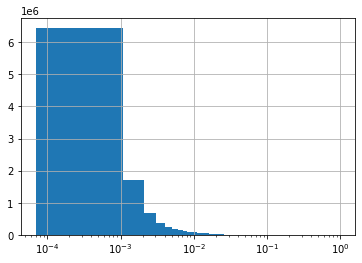

In [9]:
mut_proba.ProbaFull.hist(bins=1000)
plt.xscale("log")
plt.show()

### Proba pastml

In [10]:
path_to_mutations_pastml = "../data/processed/nematoda/dif_approaches/pastml/mutations.tsv"

mut_pastml = pd.read_csv(path_to_mutations_pastml, sep='\t')
mut_pastml["MutBase"] = mut_pastml["Mut"].str.slice(2, 5)
print(mut_pastml.shape)
mut_pastml.head()

(3615949, 15)


,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,ProbaFull,RefNode,AltNode,Gene,MutBase
0,G[T>A]A,0,53,2,GTA,GAA,V,E,0.054248,0.001046,0.001046,Node4,Node5,ATP6,T>A
1,T[T>A]A,-1,53,2,TTA,TAA,L,*,0.072780,0.002390,0.002390,Node4,Node5,ATP6,T>A
2,T[T>G]A,0,53,2,TTA,TGA,L,W,0.072780,0.000913,0.000913,Node4,Node5,ATP6,T>G
3,T[T>A]G,-1,53,2,TTG,TAG,L,*,0.029787,0.000400,0.000400,Node4,Node5,ATP6,T>A
4,G[A>G]T,0,53,2,GAT,GGT,D,G,0.012598,0.000448,0.000448,Node4,Node5,ATP6,A>G


In [11]:
msum_pr = mutations_summary(mut_pastml, "Gene", "ProbaFull")
msum_pr["syn"] += msum_pr["syn4f"]
msum_pr.round(1)

,non-syn,syn,syn4f,Stop loss,Stop gain,Stop to stop
Gene,,,,,,
ATP6,2113.6,6021.9,3314.8,16.3,5.9,0.3
COX1,2654.4,25965.5,15134.5,7.3,3.0,0.1
COX2,1795.3,10162.4,4985.8,13.7,4.6,0.8
COX3,2358.8,12416.7,6635.8,14.2,5.3,0.3
CYTB,4038.0,17189.6,9234.2,25.4,9.7,1.0
ND1,3468.2,13221.9,6864.5,14.7,4.8,0.3
ND2,4982.3,9076.2,3554.3,24.7,8.1,0.5
ND3,1649.6,3875.8,1666.3,7.8,3.4,0.1
ND4,5582.5,18137.7,9321.7,25.0,8.9,1.1


In [12]:
msum_pr = mutations_summary(mut_proba, "Gene", "ProbaFull")
msum_pr["syn"] += msum_pr["syn4f"]
msum_pr.round(1)

,non-syn,syn,syn4f,Stop loss,Stop gain,Stop to stop
Gene,,,,,,
ATP6,5697.2,4259.3,2147.5,143.1,140.1,12.7
COX1,4097.5,13217.4,7373.4,60.4,58.4,3.9
COX2,3765.8,5539.2,2615.1,71.7,69.7,5.8
COX3,3137.3,6555.7,3426.2,41.0,36.9,2.5
CYTB,5005.5,9109.5,4716.1,52.1,46.6,3.0
ND1,4653.2,7354.1,3700.5,64.3,60.2,3.5
ND2,8179.6,6107.3,2394.2,96.0,88.6,8.4
ND3,2184.0,2476.4,1081.2,29.7,27.3,2.4
ND4,6109.0,10024.7,5128.6,43.4,34.8,4.0


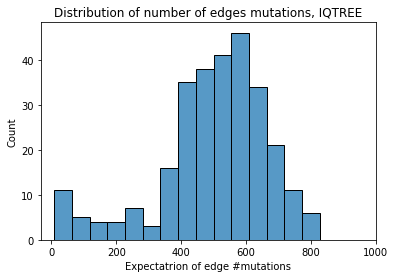

In [13]:
sns.histplot(mut_proba.groupby("AltNode").ProbaFull.sum())
plt.title("Distribution of number of edges mutations, IQTREE")
plt.xlabel("Expectatrion of edge #mutations")
plt.xlim(None, 1000)
plt.show()

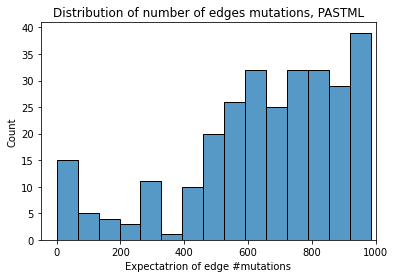

In [14]:
sns.histplot(mut_pastml.groupby("AltNode").ProbaFull.sum(), bins=15)
plt.title("Distribution of number of edges mutations, PASTML")
plt.xlabel("Expectatrion of edge #mutations")
plt.xlim(None, 1000)
plt.show()

## Mutspec

In [156]:
# mutspec_simple = pd.read_csv("../data/processed/nematoda/30-05-22-16-39-29_rooted/mutspec192.tsv", sep='\t')
# mutspec_proba  = pd.read_csv("../data/processed/nematoda/proba/mutspec192.csv", sep='\t')
# mutspec_pastml = pd.read_csv("../data/processed/nematoda/pastml/mutspec192.csv", sep='\t')

mutspec_simple = pd.read_csv("../data/processed/nematoda/dif_approaches/simple/mutspec192.tsv", sep='\t')
mutspec_proba  = pd.read_csv("../data/processed/nematoda/dif_approaches/iqtree/mutspec192.tsv", sep='\t')
mutspec_pastml = pd.read_csv("../data/processed/nematoda/dif_approaches/pastml/mutspec192.tsv", sep='\t')

### Collapse to 96

In [157]:
translator = str.maketrans("ACGT", "TGCA")


def rev_comp(mut: str):
    new_mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = new_mut.translate(translator)
    return new_mut


def collapse_mutspec(ms192: pd.DataFrame):
    assert ms192.shape[0] == 192
    ms1 = ms192[ms192.Mut.str.get(2).isin(list("CT"))]
    ms2 = ms192[ms192.Mut.str.get(2).isin(list("AG"))]
    ms2["Mut"] = ms2["Mut"].apply(rev_comp)

    ms96 = pd.concat([ms1, ms2]).groupby("Mut")[["ObsFr", "ExpFr"]].sum()
    ms96["RawMutSpec"] = ms96["ObsFr"] / ms96["ExpFr"]
    ms96["MutSpec"] = ms96["RawMutSpec"] / ms96["RawMutSpec"].sum()
    ms96 = ms96.fillna(0)
    return ms96

In [158]:
mutspec_simple = mutspec_simple.groupby(["RefNode", "AltNode", "Label"]).apply(collapse_mutspec).reset_index()
mutspec_proba = mutspec_proba.groupby(["RefNode", "AltNode", "Label"]).apply(collapse_mutspec).reset_index()
mutspec_pastml = mutspec_pastml.groupby(["RefNode", "AltNode", "Label"]).apply(collapse_mutspec).reset_index()

### Fulctions for plotting

TODO replace by AlexandrovLab functions

In [ ]:
tmp_df = pd.DataFrame({"MutExt": mutspec_simple[mutspec_simple.Label == "ff"].Mut.unique()})
tmp_df["Mut"] = tmp_df.MutExt.str.get(2) + ">" + tmp_df.MutExt.str.get(4)
tmp_df["Context"] = tmp_df.MutExt.str.get(
    0) + tmp_df.MutExt.str.get(2) + tmp_df.MutExt.str.get(-1)
tmp_df.sort_values(["Mut", "Context"], inplace=True)
order96 = tmp_df.MutExt.values
order96.shape

In [146]:
from itertools import groupby

import warnings
warnings.filterwarnings("ignore")

coloring = {
    "C>A": "lightblue",
    "C>G": "black",
    "C>T": "red",
    "T>A": "gray",
    "T>C": "green",
    "T>G": "pink",
}


def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black', linewidth=1)
    line.set_clip_on(False)
    ax.add_line(line)


def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]


def label_group_bar_table(ax, df):
    font = {
        'family': 'cursive',
        'color':  'black',
        'weight': 'normal',
        'size': 10,
    }
    rotation = 90
    ypos = -.04
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        if level == 0:
            rotation = 0
            font['size'] = 12

        pos = 0
        for label, rpos in label_len(df.index, level):
            lxpos = (pos + .5 * rpos) * scale
            ax.text(lxpos, ypos, label, ha='center', rotation=rotation,
                    fontdict=font, transform=ax.transAxes)
            if level == 0:
                add_line(ax, pos*scale, ypos)
            pos += rpos
        if level == 0:
            add_line(ax, pos*scale, ypos)
        ypos -= .05


def plot_mutspec192(edge_mutspec, label="Mutational spectra", filepath=None):
    edge_mutspec = edge_mutspec.copy()
    smpl = edge_mutspec.groupby("AltNode").get_group(edge_mutspec.AltNode.sample().item()).sort_values(["MutBase", "Context"])
    colors = smpl["MutBase"].map(coloring).values
    df = edge_mutspec.groupby(["MutBase", "Context"]).mean()
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)
    sns.barplot(
        x="Mut", y="MutSpec", data=edge_mutspec, 
        order=order96, errwidth=1, ax=fig.gca()
    )
    for bar, clr in zip(ax.patches, colors):
        bar.set_color(clr)
        bar.set_width(0.6)
    labels = ['' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    ax.set_xlabel('')
    ax.set_title(label)
    label_group_bar_table(ax, df)
    fig.subplots_adjust(bottom=.1*df.index.nlevels)
    if filepath is not None:
        plt.savefig(filepath)
    plt.show()

In [160]:
mutspec_simple["MutBase"] = mutspec_simple.Mut.str.slice(2, 5)
mutspec_simple["Context"] = mutspec_simple.Mut.str.get(0) + mutspec_simple.Mut.str.get(2) + mutspec_simple.Mut.str.get(-1)

mutspec_proba["MutBase"] = mutspec_proba.Mut.str.slice(2, 5)
mutspec_proba["Context"] = mutspec_proba.Mut.str.get(0) + mutspec_proba.Mut.str.get(2) + mutspec_proba.Mut.str.get(-1)

mutspec_pastml["MutBase"] = mutspec_pastml.Mut.str.slice(2, 5)
mutspec_pastml["Context"] = mutspec_pastml.Mut.str.get(0) + mutspec_pastml.Mut.str.get(2) + mutspec_pastml.Mut.str.get(-1)

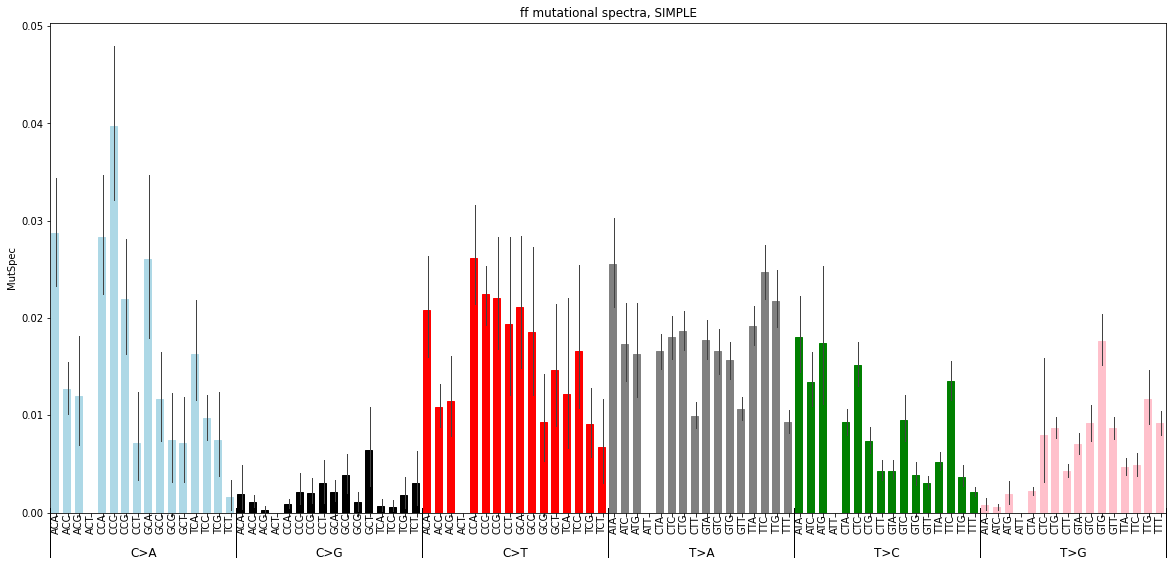

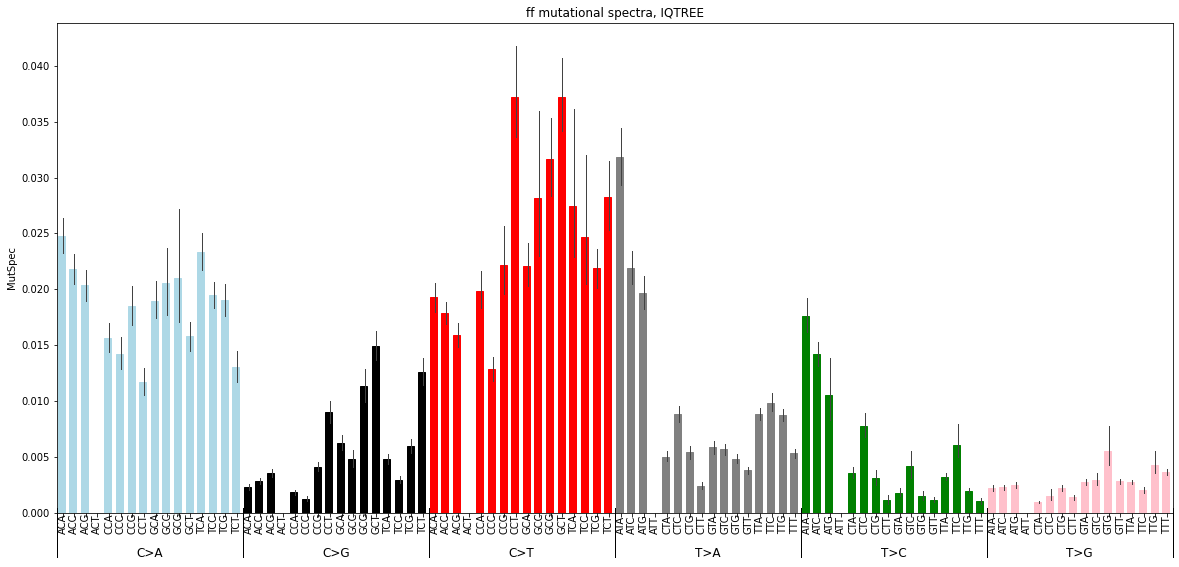

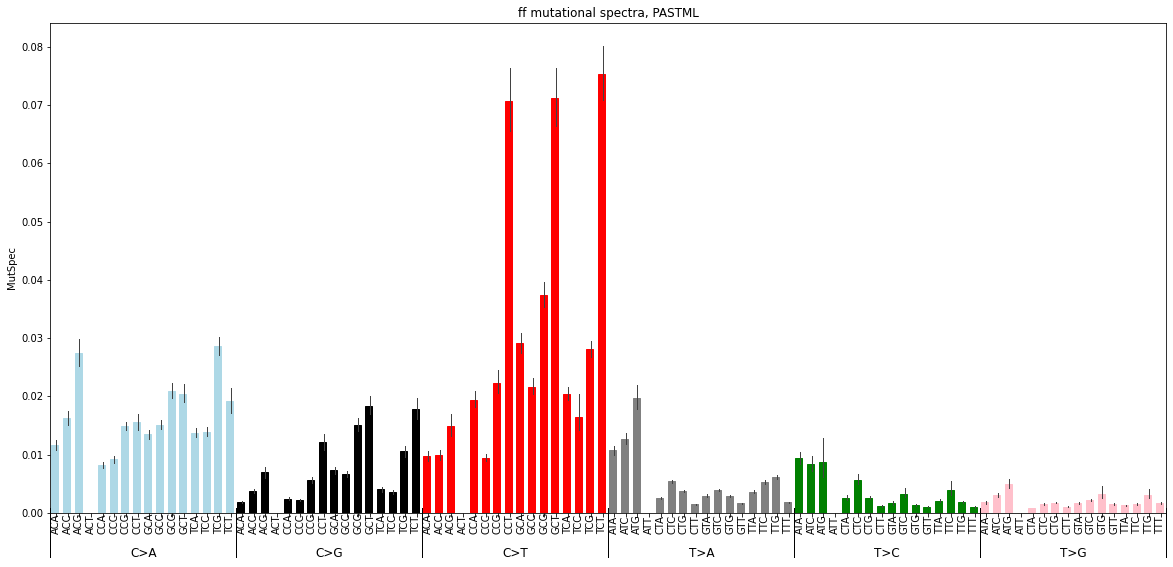

In [161]:
lbl = "ff"
plot_mutspec192(mutspec_simple[mutspec_simple.Label == lbl], f"{lbl} mutational spectra, SIMPLE")
plot_mutspec192(mutspec_proba[mutspec_proba.Label   == lbl], f"{lbl} mutational spectra, IQTREE")
plot_mutspec192(mutspec_pastml[mutspec_pastml.Label == lbl], f"{lbl} mutational spectra, PASTML")

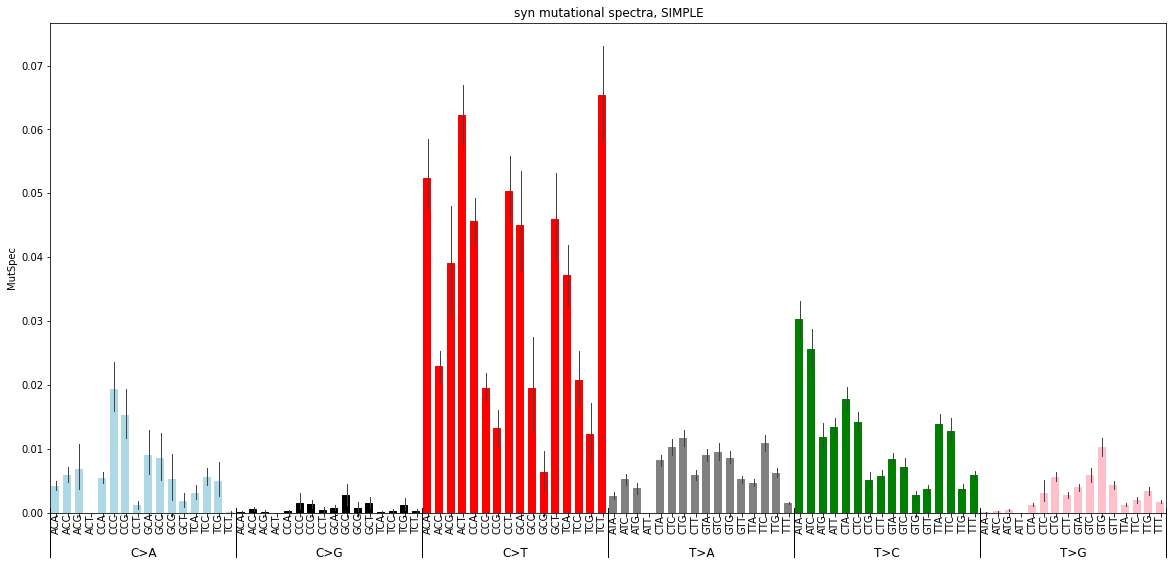

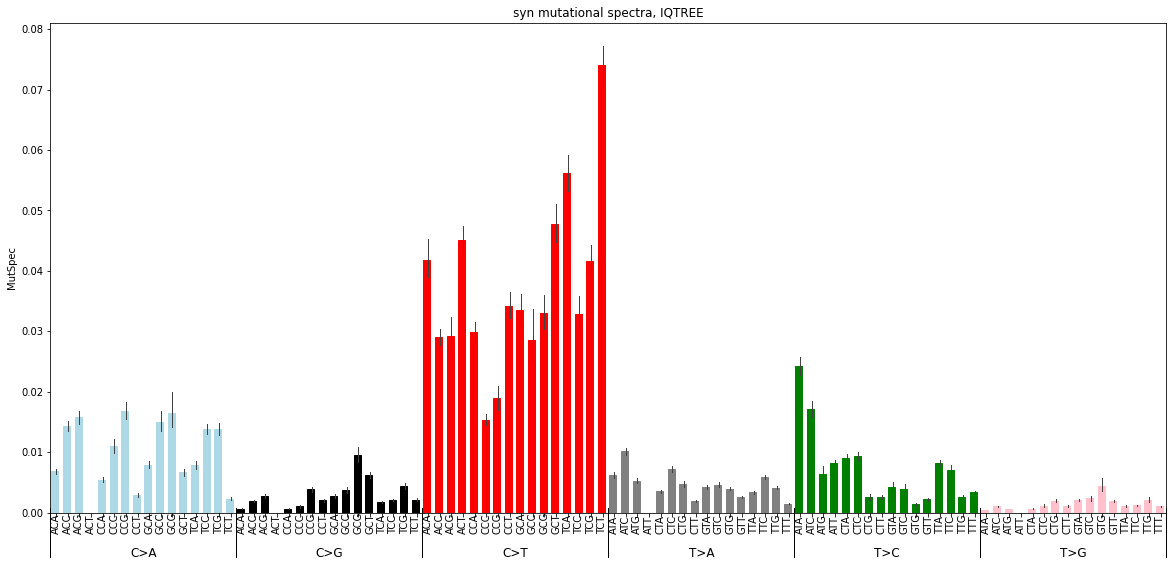

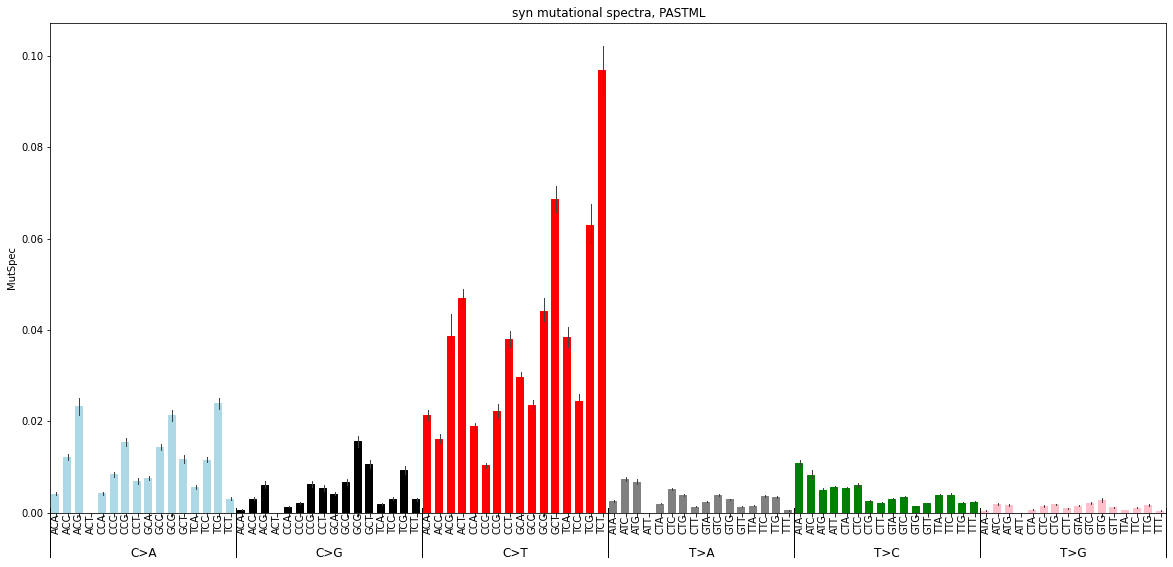

In [162]:
lbl = "syn"
plot_mutspec192(mutspec_simple[mutspec_simple.Label == lbl], f"{lbl} mutational spectra, SIMPLE")
plot_mutspec192(mutspec_proba[mutspec_proba.Label   == lbl], f"{lbl} mutational spectra, IQTREE")
plot_mutspec192(mutspec_pastml[mutspec_pastml.Label == lbl], f"{lbl} mutational spectra, PASTML")

In [165]:
df1

,RefNode,AltNode,Label,ObsFr,ExpFr,RawMutSpec,MutSpec,MutBase,Context
Mut,,,,,,,,,
A[C>A]A,Node18,Chandlerella_quiscali,syn,0,190.0,0.000000,0.000000,C>A,ACA
A[C>A]C,Node18,Chandlerella_quiscali,syn,2,68.0,0.029412,0.008036,C>A,ACC
A[C>A]G,Node18,Chandlerella_quiscali,syn,0,0.0,0.000000,0.000000,C>A,ACG
A[C>A]T,Node18,Chandlerella_quiscali,syn,0,79.0,0.000000,0.000000,C>A,ACT
A[C>G]A,Node18,Chandlerella_quiscali,syn,0,190.0,0.000000,0.000000,C>G,ACA
...,...,...,...,...,...,...,...,...,...
T[T>C]T,Node18,Chandlerella_quiscali,syn,11,1436.0,0.007660,0.002093,T>C,TTT
T[T>G]A,Node18,Chandlerella_quiscali,syn,0,505.0,0.000000,0.000000,T>G,TTA
T[T>G]C,Node18,Chandlerella_quiscali,syn,0,136.0,0.000000,0.000000,T>G,TTC


In [164]:
sims_data = []
for lbl in mutspec_simple.Label.unique():
    for anode in set(mutspec_simple.AltNode):
        df1 = mutspec_simple[(mutspec_simple.Label == lbl) & (mutspec_simple.AltNode == anode)].set_index("Mut").sort_index()
        df2 = mutspec_proba[(mutspec_proba.Label == lbl)   & (mutspec_proba.AltNode == anode) ].set_index("Mut").sort_index()
        df3 = mutspec_pastml[(mutspec_pastml.Label == lbl) & (mutspec_pastml.AltNode == anode)].set_index("Mut").sort_index()

        sim12 = 1 - spatial.distance.cosine(df1["MutSpec"], df2["MutSpec"])
        sim13 = 1 - spatial.distance.cosine(df1["MutSpec"], df3["MutSpec"])
        sim23 = 1 - spatial.distance.cosine(df2["MutSpec"], df3["MutSpec"])
        
        sims_data.append({
            "Label": lbl, "AltNode": anode, 
            "cossim simple&iqtree": sim12, "cossim simple&pastml": sim13, "cossim iqtree&pastml": sim23,
        })
sims_df = pd.DataFrame(sims_data)

In [166]:
sims_df

,Label,AltNode,cossim simple&iqtree,cossim simple&pastml,cossim iqtree&pastml
0,all,Ascaris_ovis,0.747963,0.242185,0.313237
1,all,Node129,0.400751,0.300667,0.730430
2,all,Oesophagostomum_asperum,0.764030,0.559681,0.845063
3,all,Thelazia_callipaeda,0.797638,0.600482,0.887103
4,all,Node102,0.472599,0.426807,0.764764
...,...,...,...,...,...
841,syn,Onchocerca_volvulus,0.709284,0.409492,0.839441
842,syn,Node57,0.651632,0.538889,0.925000
843,syn,Protostrongylus_rufescens,0.853264,0.755345,0.830449
844,syn,Wuchereria_bancrofti,0.689687,0.530765,0.896815


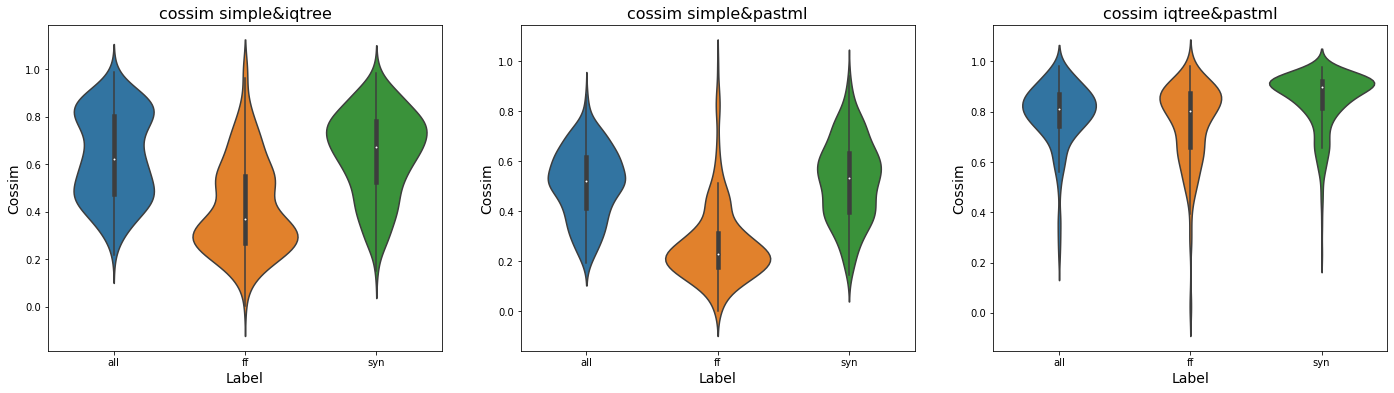

In [167]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(24, 6)
for i, cs_col in enumerate(sims_df.columns[-3:]):
    axs[i].set_xlabel(None, fontsize=14)
    axs[i].set_title(cs_col, fontsize=16)
    sns.violinplot(y=cs_col, x="Label", data=sims_df, ax=axs[i], fontdict={"fontsize": 16})
    axs[i].set_ylabel("Cossim", fontsize=14)
    